# Medical Insurance Price Prediction

## Overview
This project aims to identify the most important factors influencing medical insurance prices and to build robust machine learning models for prediction. By leveraging data sourced from Kaggle, the ultimate goal is to explore how predictive models can enhance the efficiency and profitability of health insurance companies through better risk assessment and cost management.

Data source: https://www.kaggle.com/datasets/harishkumardatalab/medical-insurance-price-prediction?resource=download

## Technical Skills Highlighted
- Conducted data preprocessing, including cleaning datasets, handling missing values, and performing EDA with visualizations to identify key attributes.
- Developed and evaluated single-variable, multi-variable, and Ridge regression models, leveraging polynomial transformations and hyperprameter tuning to improve predictions and reduce overfitting.
- Adept at model evaluation using metrics such as R square and MSE to measure predictive accuracy and ensure robustness.

## Setup Libraries

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# for regression model design
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

## Load and Prepare the Data

In [115]:
url = '/Users/graceluan/Documents/Data Science Job Hunting/Medical Insurance Price Prediction/medical_insurance_dataset.csv'
df = pd.read_csv(url,header=None)
headers = ['age','gender','bmi','no_of_child','smoker','region','charges']
df.columns = headers
# region 1,2,3,4 stands for US region NW, NE, SW, SE respectively

In [117]:
df.dtypes #age, smoker should be integer

age             object
gender           int64
bmi            float64
no_of_child      int64
smoker          object
region           int64
charges        float64
dtype: object

In [118]:
# checking nan, empty values
print(df['age'].unique())
print(df['smoker'].unique())
# discovered the question mark
df.replace('?',np.nan, inplace=True) #replace ? with nan, easy to convert to float

['19' '18' '28' '33' '32' '31' '46' '37' '60' '25' '62' '23' '56' '27'
 '52' '30' '34' '59' '63' '55' '22' '26' '35' '24' '41' '38' '36' '21'
 '48' '40' '58' '53' '43' '64' '20' '61' '44' '57' '29' '45' '54' '49'
 '47' '51' '42' '50' '39' '?']
['1' '0' '?']


In [131]:
# replece ? in age with mean
age_mean = df['age'].astype('float').mean()
df['age'].replace(np.nan, age_mean, inplace=True)
df['age'] = df['age'].astype('int')
# replace ? in smoke with mode
smk_mode = df['smoker'].value_counts()
print(smk_mode) #more 0, none smoker
df['smoker'] = df['smoker'].replace(np.nan,'0').astype('int')

smoker
0    2208
1     564
Name: count, dtype: int64


In [133]:
# price decimal too long
df['charges'] = np.round(df['charges'],2)

In [135]:
df.head(3) # the final version of dataframe ready to analyze

,age,gender,bmi,no_of_child,smoker,region,charges
0,19,1,27.90,0,1,3,16884.92
1,18,2,33.77,1,0,4,1725.55
2,28,2,33.00,3,0,4,4449.46


## EDA

### Correlation matrix

In [139]:
correlation = df.corr()

                  age    gender       bmi  no_of_child    smoker    region  \
age          1.000000 -0.026046  0.113048     0.037574 -0.023286 -0.007167   
gender      -0.026046  1.000000  0.042924     0.016020  0.082326  0.022213   
bmi          0.113048  0.042924  1.000000    -0.001492  0.011489  0.271119   
no_of_child  0.037574  0.016020 -0.001492     1.000000  0.006362 -0.025717   
smoker      -0.023286  0.082326  0.011489     0.006362  1.000000  0.054077   
region      -0.007167  0.022213  0.271119    -0.025717  0.054077  1.000000   
charges      0.298624  0.062837  0.199846     0.066442  0.788783  0.054058   

              charges  
age          0.298624  
gender       0.062837  
bmi          0.199846  
no_of_child  0.066442  
smoker       0.788783  
region       0.054058  
charges      1.000000  


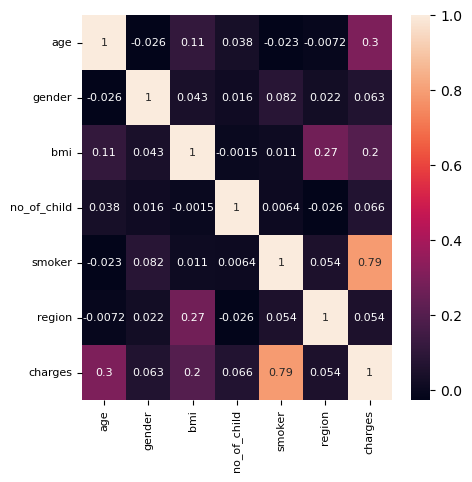

In [147]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 8}
)
# Axis ticks size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Correlation analysis shows a strong positive correlation (0.79) between smoker and charges, indicating that smoking status significantly influences medical expenses. In comparison, age and BMI show weaker correlations with charges, at 0.3 and 0.2 respectively, though they are still stronger than correlations with other variables.

### Regression Visualization

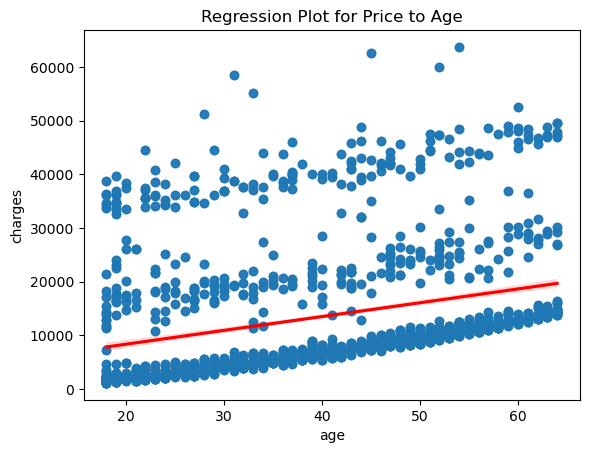

In [155]:
sns.regplot(x='age',y='charges',data=df, line_kws={'color':'red'})
plt.title('Regression Plot for Price to Age')
plt.show()

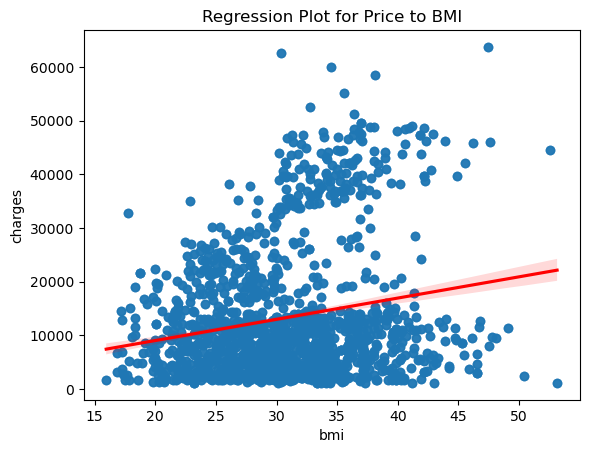

In [156]:
sns.regplot(x='bmi',y='charges',data=df, line_kws={'color':'red'})
plt.title('Regression Plot for Price to BMI')
plt.show()

Neither of the regression plots show strong fit.

<Axes: xlabel='smoker', ylabel='charges'>

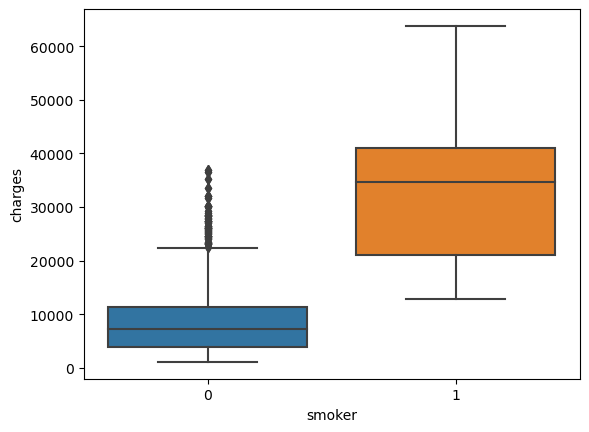

In [157]:
sns.boxplot(x='smoker', y='charges', data=df)

The plot shows that mostly smokers face higher insurance prices than non-smokers.

## Model Development

In [168]:
# Explore a simple linear regression with only smoker attribute with price.
X = df[['smoker']]
Y = df['charges']
lm = LinearRegression()
lm.fit(X,Y)
print('R2_score is:',lm.score(X,Y).round(3))

R2_score is: 0.622


In [170]:
# Use all the attributes to fit a linear regression model.
Z = df[['age','bmi','gender','no_of_child','region','smoker']]
lm.fit(Z,Y)
print('R2_score with all attributes is:',lm.score(Z,Y).round(3))

R2_score with all attributes is: 0.75


The R2 score significantly improved by adding all attributes to the model.

In [181]:
# Continue to adjust the model with polynomial features and standard scaler. Create a training pipeline.
input = [
    ('scale',StandardScaler()),
    ('Polynomial',PolynomialFeatures(include_bias=False)),
    ('model',LinearRegression())
]
pipe = Pipeline(input)


In [ ]:
Z = Z.astype('int')
pipe.fit(Z,Y)
ypipe = pipe.predict(Z)
print('R2_score with pipeline adjustment is:', r2_score(Y,ypipe).round(3))

The R2 score increases from 0.75 to 0.845,

## Model Refinement

In [179]:
# split the data to test and train set
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)

# initialize ridge regressor with hyperparameter 0.1. fit the model using the training data.
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(x_train,y_train)
yhat = ridge_model.predict(x_test)
print('Ridge model (alpha 0.1) r2 score is:', r2_score(y_test,yhat))


Ridge model (alpha 0.1) r2 score is: 0.676108526760913


In [176]:
# use grid search to try different alpha
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [177]:
param_grid = {'alpha':[0.01,0.1,1,5,10,100]}
scoring = make_scorer(r2_score)
grid_search = GridSearchCV(estimator=ridge_model,param_grid=param_grid,scoring=scoring, cv=10)
grid_search.fit(x_train,y_train)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best r2 Score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
yhat = best_model.predict(x_test)
print(f"Test 22 Score: {r2_score(y_test, yhat)}")

Best alpha: 1
Best R^2 Score: 0.7611325683236415
Test R^2 Score: 0.6763005121989585


In [180]:
# apply polynomial transformation to the training parammeters degree=2

pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
ridge_model.fit(x_train_pr, y_train)
y_hat = ridge_model.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.7836812898676733


The machine learning model was developed and refined to predict medical insurance prices, achieving an R2 score of 0.783 on the test dataset. This score indicates that the model explains approximately 78.3% of the variance in medical insurance prices, reflecting a solid predictive capability. The refinement process included regularization through Ridge regression to prevent overfitting, hyperparameter tuning to identify the optimal alpha value, and polynomial transformations to enhance feature interactions and capture non-linear relationships.

### Key Findings
1. The analysis revealed that among the six attributes—age, gender, BMI, number of children, smoker status, and region. Smoker status emerged as the most influential factor in determining insurance prices. This highlights the significant cost burden associated with smoking-related health risks. 
2. Age and BMI were moderately correlated with insurance prices, indicating that older age and higher BMI are associated with increased costs.
3. Attributes like gender, number of children, and region showed weaker impacts but still contributed to the overall prediction.

### Implications on Medical Insurance Pricing
1. Identifying key cost drivers, smoking, allows insurers to design targeted risk assessment strategies and personalized premiums.
2. Insights into the impact of BMI and age suggest opportunities for wellness programs and lifestyle interventions to mitigate long-term costs.
3. The weaker influence of attributes like gender and region indicates that pricing models can focus on more critical factors without overly penalizing certain demographics.